In [17]:
# import required libraries
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization, Conv2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [18]:
import os
dataset_path = "/kaggle/input/fer2013"
# List the contents of the dataset directory
print(os.listdir(dataset_path))

['test', 'train']


In [19]:
# create the path for dataset directories
train_data_dir = '/kaggle/input/fer2013/train'
validation_data_dir = '/kaggle/input/fer2013/test'

In [20]:
# List the different emotions of the FER2013 dataset
train_expressions = os.listdir(train_data_dir)
validation_expressions = os.listdir(validation_data_dir)

print("Emotion Categories in Train set:", train_expressions)
print("Emotion Categories in Test set:", validation_expressions)

Emotion Categories in Train set: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
Emotion Categories in Test set: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [21]:
# Dictionaries to store the image counts
train_image_counts = {expr: 0 for expr in train_expressions}
validation_image_counts = {expr: 0 for expr in validation_expressions}

# Count the number of images for each emotion category
for expr in train_expressions:
    train_image_counts[expr] = len(os.listdir(os.path.join(train_data_dir, expr)))

for expr in validation_expressions:
    validation_image_counts[expr] = len(os.listdir(os.path.join(validation_data_dir, expr)))
    
# Calculate the total number of images in the training and testing sets
total_train_images = sum(train_image_counts.values())
total_validation_images = sum(validation_image_counts.values())

# Print the counts of the images in the sets
print("\nNumber of Images per Category in Training Set:")
for expr, count in train_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Training Images: {total_train_images}")

print("\nNumber of Images per Category in Validation Set:")
for expr, count in validation_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Validation Images: {total_validation_images}")


Number of Images per Category in Training Set:
surprise: 3171
fear: 4097
angry: 3995
neutral: 4965
sad: 4830
disgust: 436
happy: 7215
Total Training Images: 28709

Number of Images per Category in Validation Set:
surprise: 831
fear: 1024
angry: 958
neutral: 1233
sad: 1247
disgust: 111
happy: 1774
Total Validation Images: 7178


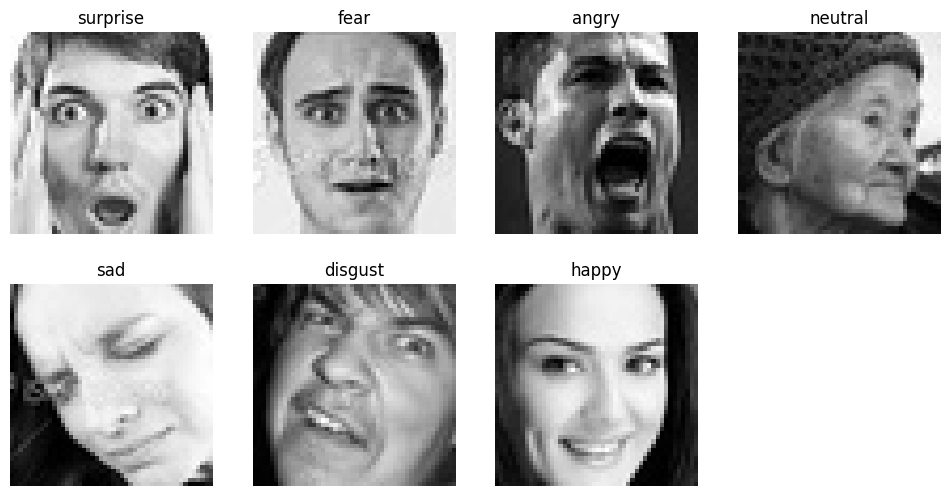

In [22]:
# visualize the images from the dataset
emotions = os.listdir(train_data_dir)
plt.figure(figsize=(12, 6))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_data_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    
    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.show()

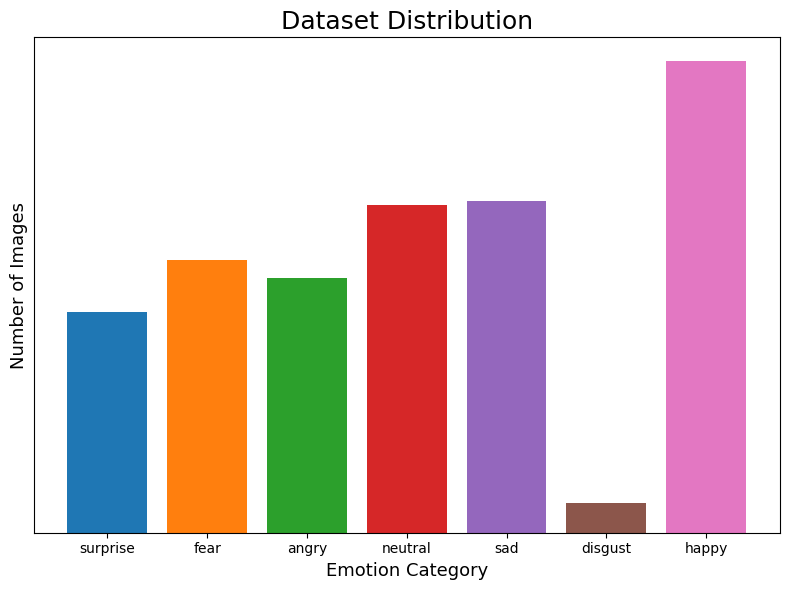

In [23]:
# Plot the dataset distribution as a graph
plt.figure(figsize=(8, 6))
colors=sns.color_palette("tab10")
plt.bar(validation_image_counts.keys(), validation_image_counts.values(), color=colors)
plt.title("Dataset Distribution", fontsize=18)
plt.xlabel("Emotion Category", fontsize=13)
plt.ylabel("Number of Images", fontsize=13)
plt.xticks(rotation=0)
plt.yticks([])
plt.tight_layout()
plt.show()

In [24]:
""""
Creation of the model:
1. Import the required libraries
2. Define the paths to the dataset
3. Perform data preparation, define the preprocessing parameters for data augmentation
4. Create the base CNN model
5. Compile the model with the specified optimizer, loss function and metrics
6. Print a summary of the model architecture
7. Train the model
8. Evaluate the model
"""
print('Model Training')

Model Training


In [25]:
# Specify the target size for images
img_size = 48
# Set the batch size
batch_size = 64

In [26]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Define the preprocessing parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,    
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale = 1./ 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset = 'validation' 
)

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
# https://www.tensorflow.org/guide/keras/sequential_model
model = Sequential()
model.add(Input(shape=(48, 48, 1)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

In [28]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,578,439 (40.35 MB)

 Trainable params: 10,574,663 (40.34 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [29]:
# https://keras.io/api/callbacks/
# define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', #Quantity to be monitored.
    factor=0.5, #Factor by which the learning rate will be reduced.
    patience=5,  #Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001, #Lower bound on the learning rate.
    verbose=1, #update messages.
)

early_stopping = EarlyStopping(
    monitor="val_loss",#Quantity to be monitored. 
    patience=10,#Number of epochs with no improvement after which training will be stopped.
    verbose=1, #displays messages when the callback takes an action.
    restore_best_weights=True,#restore model weights from the epoch with the best value of the monitored quantity.
    min_delta=0.0001 #Threshold for measuring the new optimum, to only focus on significant changes.
    
)
callbacks = [reduce_lr, early_stopping]

In [30]:
# https://www.tensorflow.org/guide/keras/training_with_built_in_methods
# Train the model
epochs = 60
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks = callbacks,
    verbose=1

)

# Save the model
model.save('/kaggle/working/final_model.h5')

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 251s 643ms/step - accuracy: 0.2449 - loss: 2.3877 - val_accuracy: 0.1731 - val_loss: 2.2549 - learning_rate: 0.0010
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - accuracy: 0.3677 - loss: 1.7206 - val_accuracy: 0.4121 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 68s 188ms/step - accuracy: 0.4398 - loss: 1.4988 - val_accuracy: 0.4776 - val_loss: 1.3522 - learning_rate: 0.0010
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 352ms/step - accuracy: 0.4818 - loss: 1.3843 - val_accuracy: 0.3158 - val_loss: 2.0296 - learning_rate: 0.0010
Epoch 5/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 199s 543ms/step - accuracy: 0.5056 - loss: 1.3154 - val_accuracy: 0.4983 - val_loss: 1.2887 - learning_rate: 0.0010
Epoch 6/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.5207 - loss: 1.2441 - val_accuracy: 0.4804 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 7/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - accuracy: 0.5443 - lo

In [31]:
# Evaluation of the model on the sets
train_loss,train_acc=model.evaluate(train_generator)
val_loss,val_acc=model.evaluate(validation_generator)
test_loss, test_acc = model.evaluate(test_generator)
print("Training Accuracy:{:.2f}%".format(train_acc*100))
print("Validation Accuracy:{:.2f}%".format(val_acc*100))
print("Test Accuracy:{:.2f}%".format(test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.7700 - loss: 0.6248
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5993 - loss: 1.1003
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 401ms/step - accuracy: 0.6666 - loss: 0.9878
Training Accuracy:76.96%
Validation Accuracy:65.25%
Test Accuracy:66.41%


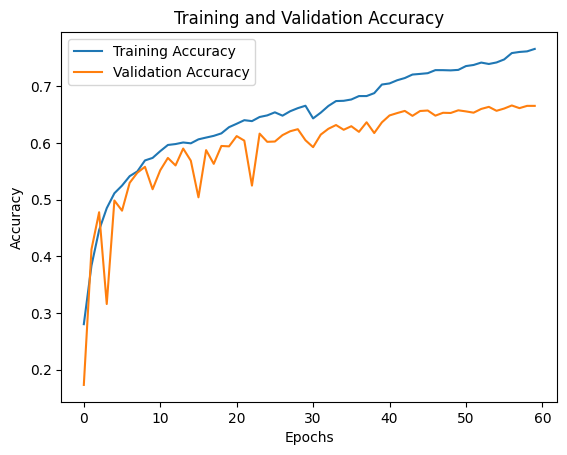

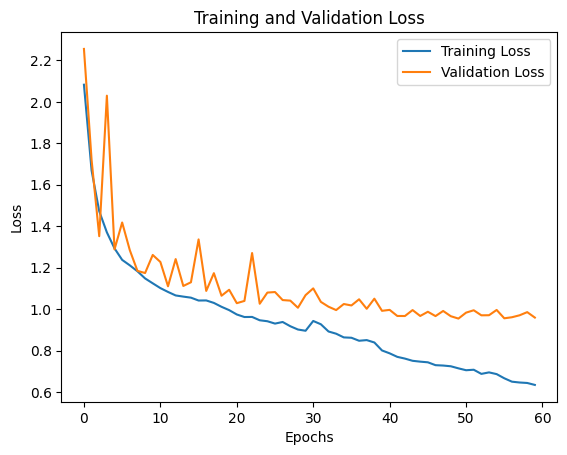

In [32]:
# Plot the graphs
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step


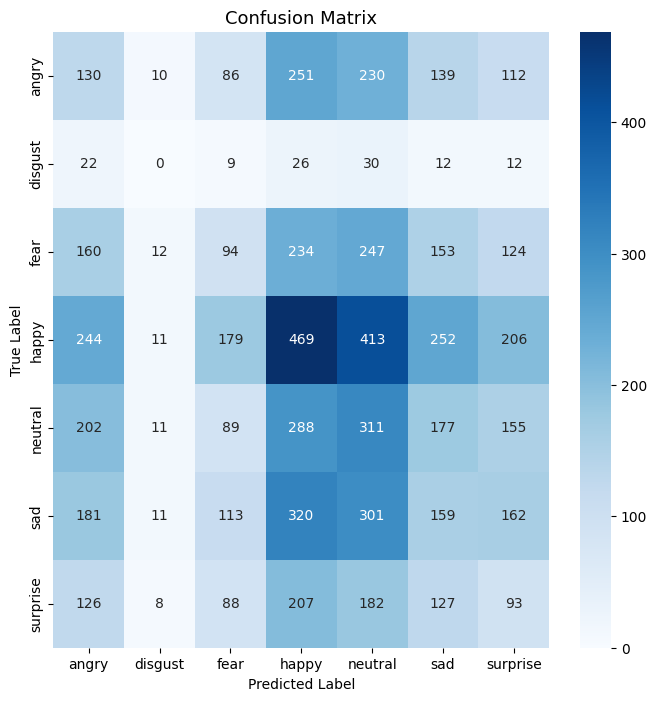

In [40]:
#Load the trained model
model = load_model("/kaggle/working/final_model.h5")

# Get the true labels from the test generator
y_true = test_generator.classes 
# Class names
labels = list(test_generator.class_indices.keys()) 

# Get predictions
y_pred = model.predict(test_generator)
# Convert to class labels
y_pred = np.argmax(y_pred, axis=1)  
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))

sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels=labels, 
            yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",fontsize=13)
plt.show()

In [41]:
# Load the trained model
model = load_model("/kaggle/working/final_model.h5")

# Load validation data, class names and the true labels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Get predictions
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.58      0.57       799
     disgust       0.71      0.53      0.61        87
        fear       0.54      0.36      0.43       819
       happy       0.83      0.88      0.85      1443
     neutral       0.56      0.68      0.61       993
         sad       0.54      0.51      0.53       966
    surprise       0.74      0.79      0.77       634

    accuracy                           0.65      5741
   macro avg       0.64      0.62      0.62      5741
weighted avg       0.64      0.65      0.64      5741



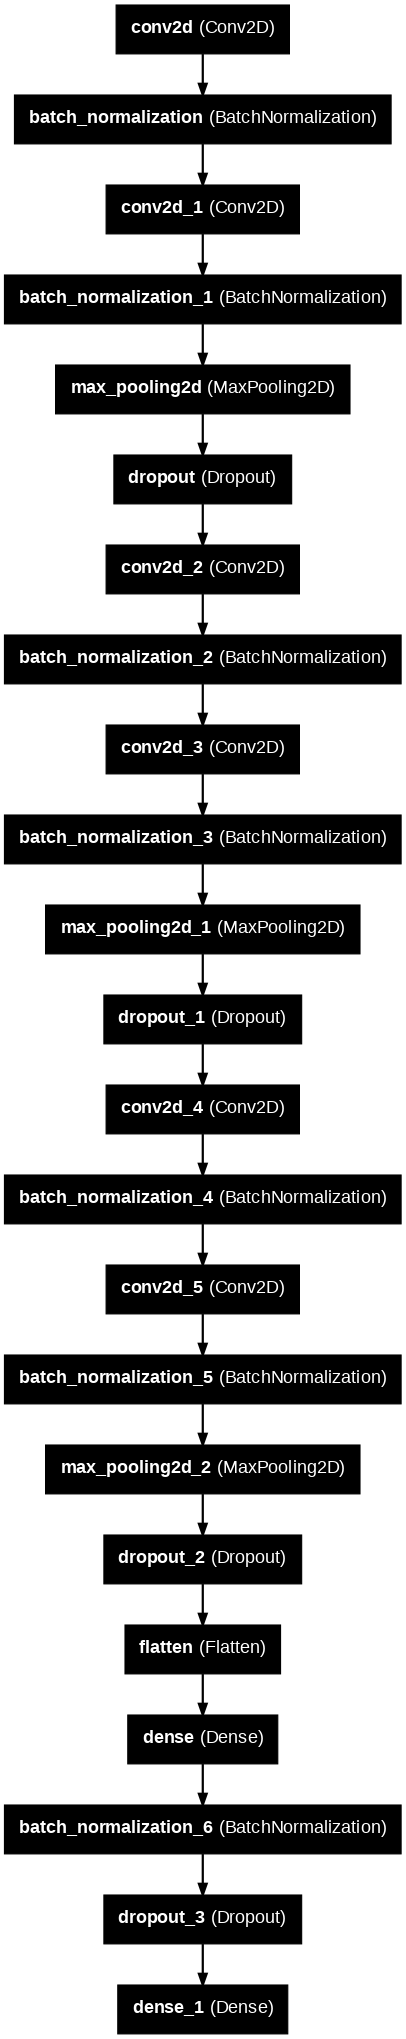

In [37]:
# Model structure
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=False, show_layer_names=True, dpi=80)